In [1]:
!nvidia-smi

Tue Apr  1 13:36:14 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.03             Driver Version: 572.60         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...    On  |   00000000:01:00.0 Off |                  N/A |
| N/A   52C    P3             13W /   61W |       0MiB /   6141MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Training Accuracy: 0.6736
Testing Accuracy: 0.6772
Classification Report:
               precision    recall  f1-score   support

         0.0       0.65      0.78      0.71     16584
         1.0       0.72      0.58      0.64     16749

    accuracy                           0.68     33333
   macro avg       0.68      0.68      0.67     33333
weighted avg       0.68      0.68      0.67     33333



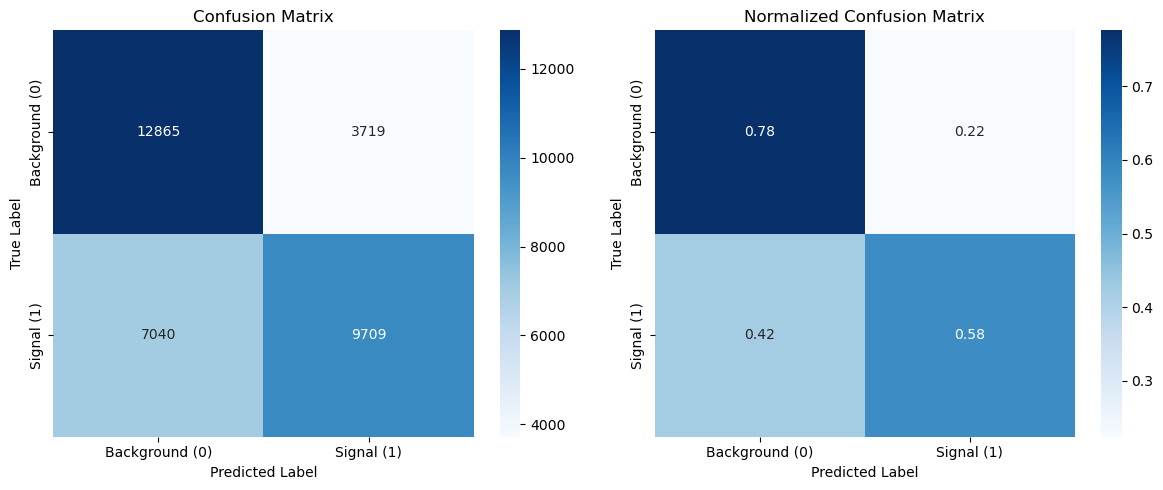

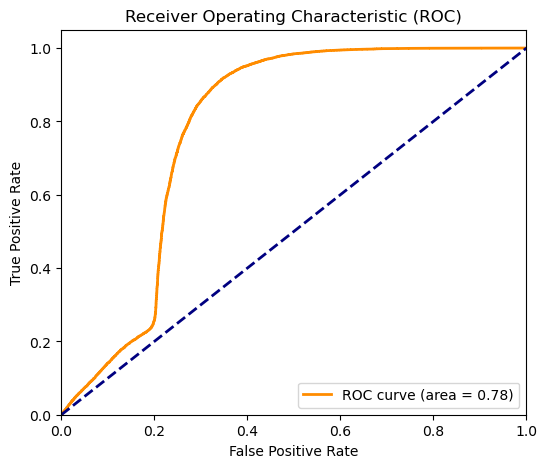

ROC AUC Score: 0.7812
CPU times: user 46min 9s, sys: 5.55 s, total: 46min 15s
Wall time: 46min 30s


In [1]:
%%time
import cudf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# ---------------------------
# 1. Load and Prepare Data
# ---------------------------
all_train = cudf.read_csv("all_train.csv").sample(n=66667, random_state=42)
all_test = cudf.read_csv("all_test.csv").sample(n=33333, random_state=42)

# Convert to pandas for sklearn
all_train = all_train.to_pandas()
all_test = all_test.to_pandas()

# ---------------------------
# 2. Extract Features and Labels
# ---------------------------
X_train = all_train.drop("# label", axis=1)
y_train = all_train["# label"]

X_test = all_test.drop("# label", axis=1)
y_test = all_test["# label"]

# ---------------------------
# 3. Train SVM Model
# ---------------------------
model = SVC(probability=True, random_state=42)
model.fit(X_train, y_train)

# ---------------------------
# 4. Compute Accuracy
# ---------------------------
train_accuracy = model.score(X_train, y_train)
test_accuracy = model.score(X_test, y_test)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

# ---------------------------
# 5. Make Predictions
# ---------------------------
y_pred = model.predict(X_test)

# ---------------------------
# 6. Classification Report
# ---------------------------
print("Classification Report:\n", classification_report(y_test, y_pred))

# ---------------------------
# 7. Confusion Matrix
# ---------------------------
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

class_names = ["Background (0)", "Signal (1)"]

# ---------------------------
# 8. Plot Confusion Matrices
# ---------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.subplots_adjust(wspace=0.5)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")
axes[0].set_title("Confusion Matrix")

sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")
axes[1].set_title("Normalized Confusion Matrix")

plt.tight_layout()
plt.show()

# ---------------------------
# 9. ROC Curve and ROC AUC Score
# ---------------------------
y_scores = model.decision_function(X_test)
roc_auc = roc_auc_score(y_test, y_scores)
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")
